In [1]:
# hide
%load_ext autoreload
%autoreload 2

# Adult income dataset

Here we wll study the Adult Income Dataset and see how we can apply Homomorphic Random Forest to it.

## Data loading

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)

df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

# df = df.sample(frac=0.1, random_state=1)
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) #Turning response into 0 and 1

seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

## Data preprocessing

Because we need our data to be in the range$[-1,1]$ at the beginning, we will create a preprocessing pipeline using sklearn Pipelines. 

It will apply a LabelEncoder on categorical columns, before using it in a MinMaxScaler.

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

class ColumnSelector(BaseEstimator, TransformerMixin):
    """Sklearn pipeline to select a column from a dataframe"""
    def fit(self, column):
        self.column = column
        
    def transform(self, X):
        return X[self.column].values
    
    def inverse_transform(self, X):
        return X
    
class Reshaper(BaseEstimator, TransformerMixin):
    """Reshapes a numpy array from 1D to 2D"""
    def transform(self, X):
        return X.reshape(-1,1)
    
    def inverse_transform(self, X):
        return X.reshape(-1)

In [4]:
class Featurizer(BaseEstimator, TransformerMixin):
    """Featurizer which normalize a dataset to [-1,1]"""
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        
    def fit(self, df):
        pipelines = []
        for col in df.columns.values:
            steps = []
            column_selector = ColumnSelector()
            column_selector.fit(col)
            
            column_values = column_selector.transform(df)
            
            steps.append((col,column_selector))
            
            if col in self.categorical_columns:
                le = LabelEncoder()
                le.fit(column_values)
                column_values = le.transform(column_values)
                
                steps.append(("label_encoding",le))
                
            reshaper = Reshaper()
            column_values = reshaper.transform(column_values)
            steps.append(("reshape", reshaper))
            
            min_max = MinMaxScaler()
            min_max.fit(column_values)
            steps.append(("min_max", min_max))
            
            pipeline = Pipeline(steps)
            pipelines.append((col, pipeline))

        self.pipelines = FeatureUnion(pipelines)
        return self
    
    def transform(self, df):
        return self.pipelines.transform(df)

Now that we have defined the featurizer, we can use it on our dataset.

In [5]:
categorical_columns = ["WorkClass","Education","MaritalStatus", "Occupation", "Relationship", 
                       "Race", "Gender", "NativeCountry"]

featurizer = Featurizer(categorical_columns)

In [6]:
X_train_normalized = featurizer.fit_transform(X_train)

We can have a look and check that input is in $[-1,1]$.

In [7]:
X_train_normalized[:2]

array([[0.30136986, 0.75      , 0.11883726, 0.06666667, 0.4       ,
        0.33333333, 1.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.39795918, 0.95      ],
       [0.50684932, 0.75      , 0.06202921, 0.6       , 0.8       ,
        0.33333333, 0.28571429, 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.39795918, 0.95      ]])

## Neural Random Forest

In [8]:
import torch
import numpy as np

Now that data has been preprocessed, we can feed it to a Neural Random Forest.

Here we can have a look at the activation function we will use, for instance sigmoid.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1a67172730>)

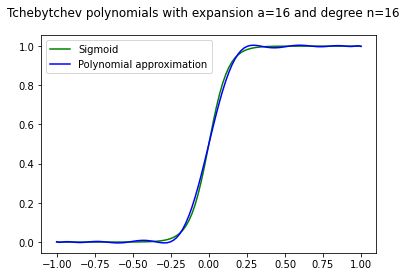

In [9]:
from cryptotree.tree import NeuralRandomForest, SigmoidTreeMaker, TanhTreeMaker
from cryptotree.polynomials import plot_graph_function_approximation

max_depth = 3

dilatation_factor = 16
polynomial_degree = dilatation_factor

plot_graph_function_approximation(torch.sigmoid,
                                  dilatation_factor=dilatation_factor,polynomial_degree=polynomial_degree)

Now that we have te parameters of dilation and polynomial degree for the activation functions, we can create the tree makers.

In [10]:
sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

tanh_tree_maker = TanhTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

We can fit a regular sklearn Random Forest now.

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

From the regular RF, we can define the Neural Random Forest, with sigmoid and tanh activations.

### Without finetuning

In [12]:
sigmoid_neural_rf = NeuralRandomForest(rf.estimators_, sigmoid_tree_maker)
tanh_neural_rf = NeuralRandomForest(rf.estimators_, tanh_tree_maker)

In [13]:
with torch.no_grad():
    sigmoid_neural_pred = sigmoid_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()
    tanh_neural_pred = tanh_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

pred = rf.predict(X_train_normalized)
print(f"Original accuracy : {(pred == y_train).mean()}")

print(f"Accuracy of sigmoid  : {(sigmoid_neural_pred == y_train).mean()}")
print(f"Accuracy of tanh : {(tanh_neural_pred == y_train).mean()}")

print(f"Match between sigmoid and original : {(sigmoid_neural_pred == pred).mean()}")
print(f"Match between tanh and original : {(tanh_neural_pred == pred).mean()}")

Original accuracy : 0.8257831695331695
Accuracy of sigmoid  : 0.29549293611793614
Accuracy of tanh : 0.7574477886977887
Match between sigmoid and original : 0.14139281326781328
Match between tanh and original : 0.9136977886977887


We can see that there is a discrepancy between the original Random Forest and the neural ones, especially for the sigmoid one.

Nonetheless we can correct this error by finetuning the final layer of our neural networks to take into account the fact that due to using activation functions not sharp enough.

### With finetuning

Because we need to make sure that at each step of the Neural Network the output is in $[-1,1]$, to be able to use the polynomial approximation of the activation, we can only safely train the last layer.

To do so we will use Pytorch and [fastai](https://github.com/fastai/fastai).

Here we first define our Pytorch Dataset.

In [14]:
from torch.utils import data
import numpy as np

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

Then we split our training data into training and validation.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
X_train_normalized, X_valid_normalized, y_train, y_valid = train_test_split(featurizer.transform(X_train), 
                                                                            y_train,
                                                                            train_size=0.8)

Then we create the Pytorch dataloaders.

In [16]:
train_ds = TabularDataset(X_train_normalized, y_train.values)
valid_ds = TabularDataset(X_valid_normalized, y_valid.values)

In [17]:
bs = 128

train_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=bs)
fix_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=False)

Here we will just define the model, which is a sigmoid Neural Random Forest.

In [18]:
tree_maker = sigmoid_tree_maker

model = NeuralRandomForest(rf.estimators_, tree_maker=tree_maker)

Because we only want to train the last layer, we will freeze the first two layers and check they are frozen.

In [19]:
model.freeze_layer("comparator")
model.freeze_layer("matcher")

for p in model.parameters():
    print(p.shape, p.requires_grad)

torch.Size([14, 7, 100]) False
torch.Size([7, 100]) False
torch.Size([8, 7, 100]) False
torch.Size([8, 100]) False
torch.Size([2, 8, 100]) True
torch.Size([2, 100]) True


In [20]:
pred = rf.predict(X_train_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8248872252615415
Accuracy : 0.2970534600249544
Same output : 0.14276801996352817


Now we can define our fastai Learner, with the dataset, the model, and the loss function, which is a Label Smoothing Cross Entropy here.

In [21]:
from fastai.basic_data import DataBunch
from fastai.tabular.learner import Learner
from fastai.metrics import accuracy

from cryptotree.tree import CrossEntropyLabelSmoothing
import torch.nn as nn

data = DataBunch(train_dl, valid_dl,fix_dl=fix_dl)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, model, loss_func=criterion, metrics=accuracy)

We will use fastai lr finder to have an idea of what learning rate to choose.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


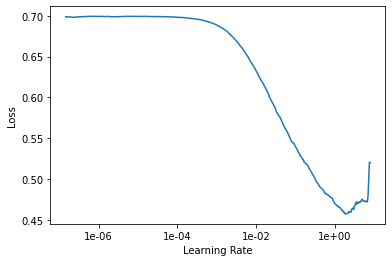

In [22]:
learn.lr_find(num_it=500)
learn.recorder.plot()

Here we can see that a good learning rate should be around 1e-1.

We can now fine tune our model.

In [23]:
learn.fit_one_cycle(5,1e-1 / 2)

epoch,train_loss,valid_loss,accuracy,time
0,0.499629,0.465686,0.821881,00:08
1,0.440183,0.436911,0.836468,00:09
2,0.425044,0.424730,0.842418,00:06
3,0.424302,0.422548,0.845489,00:04
4,0.420548,0.422337,0.844530,00:04


Here we can have a look at the performance of the Neural Random Forest tuned with respect to the original sklearn Random Forest.

In [24]:
pred = rf.predict(X_valid_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_valid_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_valid).mean()}")
print(f"Accuracy : {(neural_pred == y_valid).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8293666026871401
Accuracy : 0.8445297504798465
Same output : 0.9165067178502879


## Homomorphic Random Forest

Now that we have seen how a Neural Random Forest can be obtained and fine tuned from a regular sklearn Random Forest, we can now see how its Homomorphic Random Forest counterpart performs.

To do so, we must first initialize the parameters of the CKKS SEAL library, and choose the polynomial activation function we want. Here we will use the same activation function as the above Neural Random Forest.

In [25]:
import numpy as np 

dilatation_factor = 16
degree = dilatation_factor

PRECISION_BITS = 30
UPPER_BITS = 9

polynomial_multiplications = int(np.ceil(np.log2(degree))) + 1
n_polynomials = 2
matrix_multiplications = 2

depth = matrix_multiplications + polynomial_multiplications * n_polynomials

poly_modulus_degree = 16384

moduli = [PRECISION_BITS + UPPER_BITS] + (depth) * [PRECISION_BITS] + [PRECISION_BITS + UPPER_BITS]
print(moduli)
print(sum(moduli))

[39, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 39]
438


Now we just need to use the parameters defined above to populate our environment with SEAL context.

In [26]:
from cryptotree.seal_helper import create_seal_globals, append_globals_to_builtins
import builtins

create_seal_globals(globals(), poly_modulus_degree, moduli, PRECISION_BITS)
append_globals_to_builtins(globals(), builtins)

We can then create our Homomorphic Random Forest from the Neural Random Forest we fine tuned earlier.

We first have to extract the weights using the Homomorphic Random Forest class, and pass it to the Homomorphic Tree Evaluator which will do the computation, using the polynomial activation given, and the SEAL context.

A featurizer is also created for the client side, in order to preprocess, encode and encrypt the data.

In [60]:
from cryptotree.cryptotree import HomomorphicNeuralRandomForest, HomomorphicTreeEvaluator, HomomorphicTreeFeaturizer
from cryptotree.polynomials import polyeval_tree

h_rf = HomomorphicNeuralRandomForest(model)

tree_evaluator = HomomorphicTreeEvaluator.from_model(h_rf, tree_maker.coeffs, 
                                                   polyeval_tree, evaluator, encoder, relin_keys, galois_keys, 
                                                   scale)

homomorphic_featurizer = HomomorphicTreeFeaturizer(h_rf.return_comparator(), encoder, encryptor, scale)

Now we can take some data, encrypt it, and pass it to our Homorphic Tree Evaluator : 

In [57]:
i = 0

x = X_train_normalized[i]
ctx = homomorphic_featurizer.encrypt(x)

outputs = tree_evaluator(ctx)

We can decrypt and decode the data to see the output :

In [59]:
from seal import Plaintext, DoubleVector

homomorphic_pred = []

for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    homomorphic_pred.append(output)
    
print(homomorphic_pred)

[-0.4071502685546873, 0.30783081054687367]


We can see what was the original output, if we had used only the Neural Random Forest : 

In [30]:
x = X_train_normalized[i]

pred = rf.predict_proba(x.reshape(1,-1))
neural_pred = model(torch.tensor(x).float().unsqueeze(0))

print(f"Original Random Forest output : {pred}")
print(f"Neural Random Forest output : {neural_pred.detach()}")
print(f"Homomorphic Random Forest output : {homomorphic_pred}")

Original Random Forest output : [[0.534379 0.465621]]
Neural Random Forest output : tensor([[-0.4267,  0.3415]])
Homomorphic Random Forest output : [-0.40974426269531333, 0.31212615966796686]


Here we can see our Neural Random Forest, and Homomorphic Random Forest have very similar outputs.

## Exporting featurizer and models

In [63]:
from pathlib import Path

In [64]:
path = Path("seal")

In [72]:
from seal import EncryptionParameters

In [73]:
from seal import SEALContext

In [76]:
from seal import *

In [78]:
public_key.save(str(path/"pk"))

In [82]:
!ls seal

parms  pk


In [86]:
secret_key.save(str(path/"sk"))

In [87]:
secret_key = SecretKey()

In [89]:
relin_keys.save(str(path/"relin_keys"))

In [91]:
relin_keys = RelinKeys()
relin_keys.load(context, str(path/"relin_keys"))

In [84]:
parms = EncryptionParameters(scheme_type.CKKS)
parms.load(str(path/"parms"))

In [80]:
public_key = PublicKey()
public_key.load(context, str(path/"pk"))

In [71]:
parms.save("seal/parms")

In [35]:
import pickle

In [36]:
pickle.dump(featurizer, open("featurizer","wb"))

In [37]:
featurizer = pickle.load(open("featurizer.pkl","rb"))

In [61]:
homomorphic_featurizer.save("comparator.pkl")

In [51]:
from seal import Encryptor, Evaluator, CKKSEncoder

second_encryptor = Encryptor(context, public_key)

In [46]:
from seal import SEALContext

In [49]:
s_context = SEALContext.Create(parms)

s_evaluator = Evaluator(s_context)

s_encoder = CKKSEncoder(s_context)

In [31]:
path = "adult_income_neural_rf.pth"

torch.save(model.state_dict(), path)

In [32]:
model = NeuralRandomForest(rf.estimators_, tree_maker=tree_maker)

In [33]:
model.load_state_dict(torch.load(path))
model.eval()

NeuralRandomForest()

In [34]:
pred = rf.predict(X_valid_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_valid_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_valid).mean()}")
print(f"Accuracy : {(neural_pred == y_valid).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8293666026871401
Accuracy : 0.8445297504798465
Same output : 0.9165067178502879
